In [1]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.close('all')

# making sqllite connection to local machine
sqlite_file = 'lahman2014.sqlite'
conn = sq.connect(sqlite_file)

Here I used basic SQL code to extract the data out of the file. I separately extract data from the tables I need as it makes 
it easier to conceptualize for me. I drop any rows that contain any empty cells at all, as each information on the row is
essential for calculating the winning percentage. I then merge the two tables using pandas on the yearID and teamID columns
to make sure those two columns are concurrently equal to pull each unique team from every year. I then calculate the win
percentage by creating a new column, and sort it descending for added visibility.

In [2]:
# extracting table that has the pay
salary_query = "SELECT YearID, TeamID, sum(Salary) as payroll FROM Salaries group by YearId, TeamID"
sal_df = pd.read_sql(salary_query, conn)
sal_df.dropna(axis = 'index', inplace = True)

#extracting the table that containsn the Wins and Games
W_L_query = "SELECT YearID, TeamID, G, W FROM Teams"
ratio_df = pd.read_sql(W_L_query, conn)
ratio_df.dropna(axis = 'index', inplace = True)

# merging the 2 tables on yearID and teamID
df = pd.merge(sal_df, ratio_df, how = 'inner', left_on = ['yearID','teamID'], right_on = ['yearID','teamID'])

df["WinningPrcnt"] = (df["W"] / df["G"])*100
df.sort_values(by='WinningPrcnt', ascending=False, inplace = True)
df['yearDT']= pd.to_datetime(df['yearID'], format = '%Y')
df

,yearID,teamID,payroll,G,W,WinningPrcnt,yearDT
462,2001,SEA,74720834.0,162,116,71.604938,2001-01-01
366,1998,NYA,66806867.0,162,114,70.370370,1998-01-01
271,1995,CLE,37937835.0,144,100,69.444444,1995-01-01
42,1986,NYN,15393714.0,162,108,66.666667,1986-01-01
350,1998,ATL,61186000.0,162,106,65.432099,1998-01-01
...,...,...,...,...,...,...,...
359,1998,FLO,41322667.0,162,54,33.333333,1998-01-01
301,1996,DET,23438000.0,162,53,32.716049,1996-01-01
529,2004,ARI,69780750.0,162,51,31.481481,2004-01-01
808,2013,HOU,17890700.0,162,51,31.481481,2013-01-01


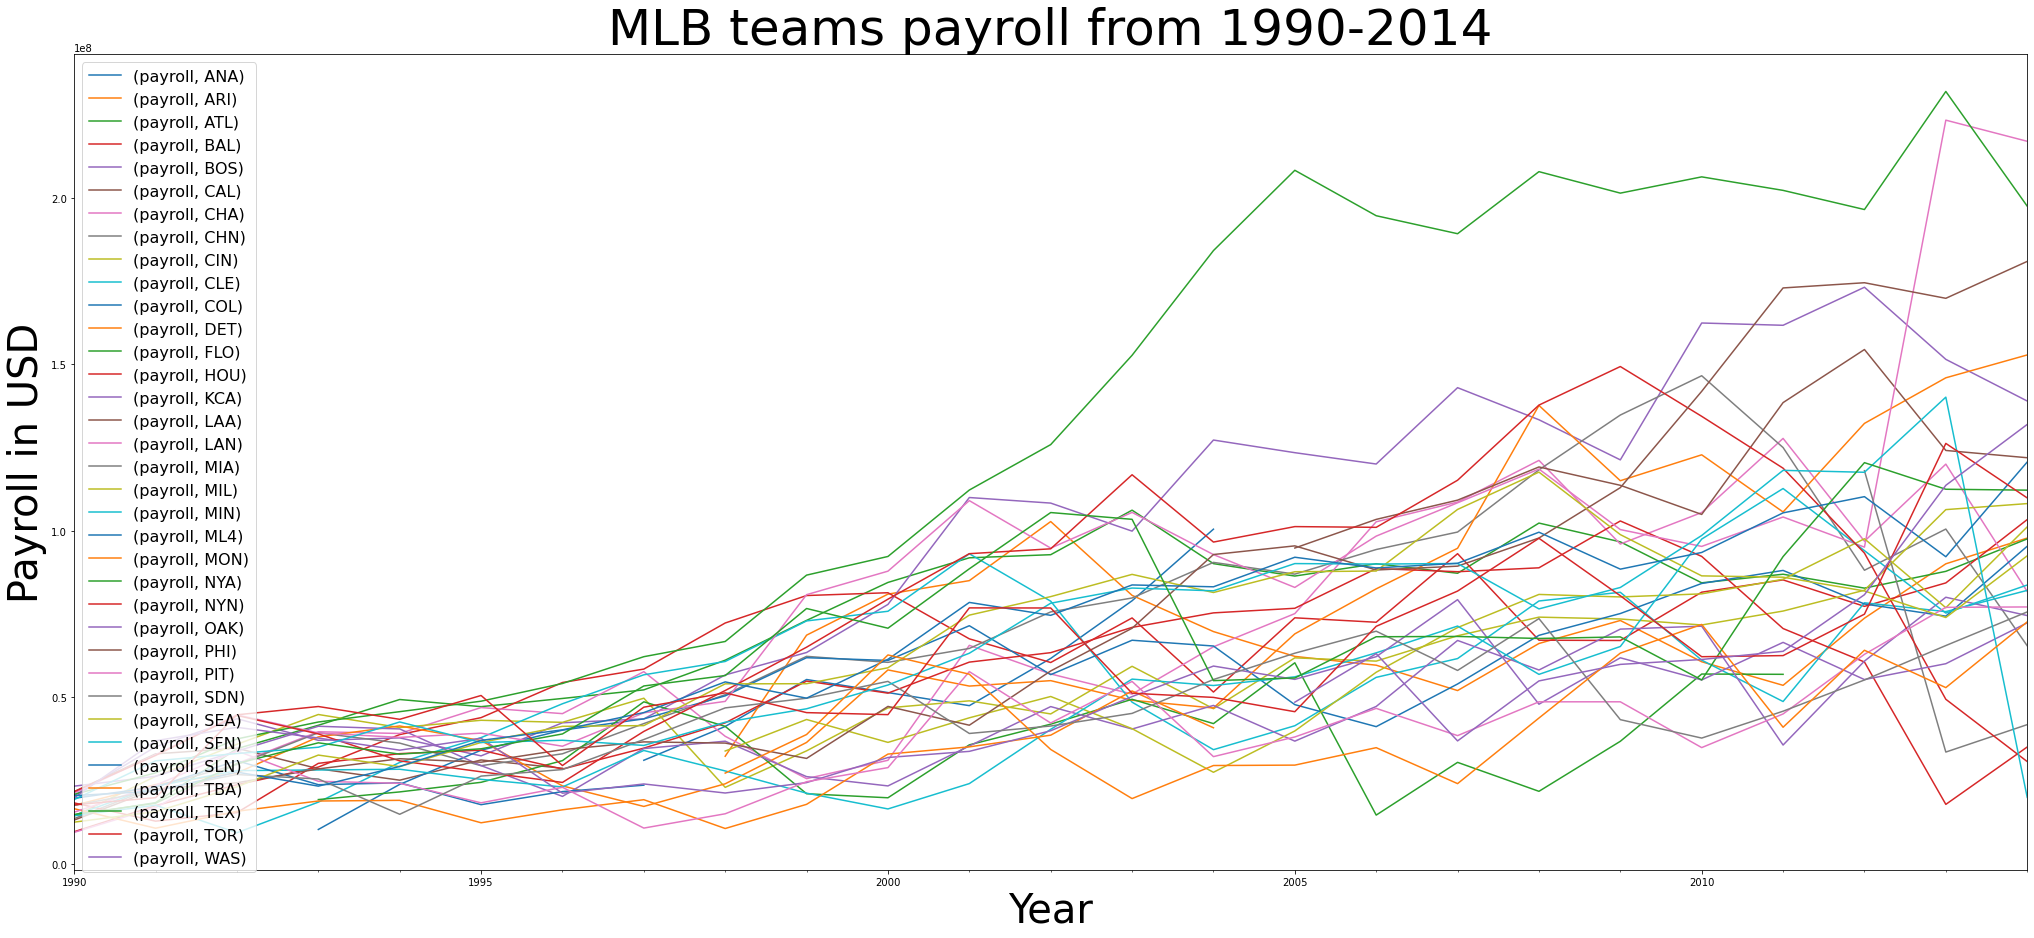

In [3]:
#filtering df by making it values only after 1990
payPlt = df[df.yearDT >= '1990']
payPlt = payPlt.pivot_table(index = ['yearDT'], columns = ['teamID'], values = ['payroll'])

#editing graph labels and output
ax1 = payPlt.plot(figsize=(35,15))
ax1.set_title('MLB teams payroll from 1990-2014', fontsize=50)
ax1.set_xlabel('Year', fontsize=40)
ax1.set_ylabel('Payroll in USD', fontsize=40)
ax1.legend(fontsize=16)


From looking at the graph, the range between the team with the highest payroll and the team with the lowest payroll has increased throughout the years. In other words, the gap between the spending power of each individual team has increased at a steady rate (aka standard deviation increased). In baseball/sports terms, this could lead to longer periods of teams dominating the league or being towards the bottom of the league in terms of performance.

Another observation is that the team with the lowest payroll in 2014 has a similar amount to the team with the lowest payroll all the way back in 1990, which is very surprising.

C:\Users\ozarr\AppData\Local\Temp\ipykernel_37604\2424464387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['max_payroll'] = df1.groupby('yearID')['payroll'].transform('max')
C:\Users\ozarr\AppData\Local\Temp\ipykernel_37604\2424464387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['min_payroll'] = df1.groupby('yearID')['payroll'].transform('min')
C:\Users\ozarr\AppData\Local\Temp\ipykernel_37604\2424464387.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

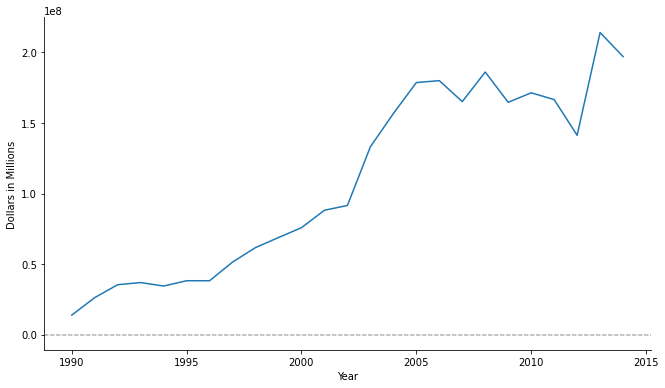

In [4]:
df1 = df[df.yearDT >= '1990']
df1['max_payroll'] = df1.groupby('yearID')['payroll'].transform('max')
df1['min_payroll'] = df1.groupby('yearID')['payroll'].transform('min')
df1['payroll_diff'] = df1['max_payroll'] - df1['min_payroll']

df1 = df1.drop_duplicates(subset=['yearID'], keep='last')
#print(df1.sort_values(by=['yearID']))

# using seaborn because matplotlib was pissing me off
g = sns.relplot(
    data=df1,
    x="yearID", y="payroll_diff",
    height=5.5, aspect=1.7, kind="line"
)
(g.map(plt.axhline, y=0, color=".7", dashes=(3, 1), zorder=1)
  .set_axis_labels("Year", "Dollars in Millions")
  .tight_layout(w_pad=0))

As seen from the plot, the dollar difference between the team with the highest and lowest payrolls has increased from around 300,000 to around 2,000,000 in 25 years. 

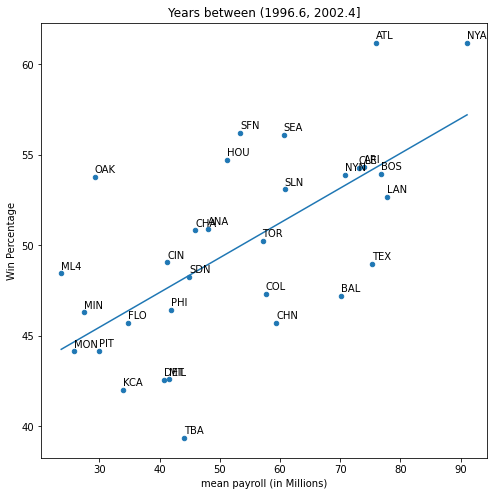

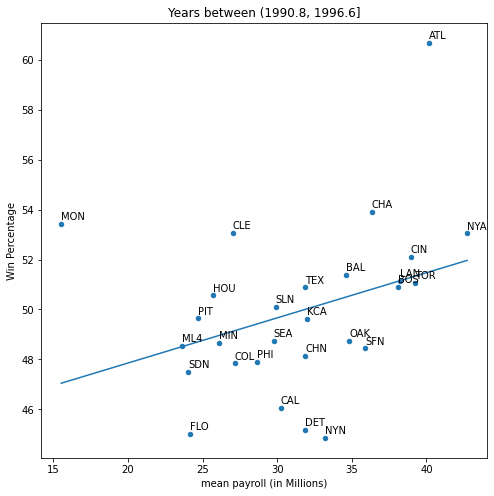

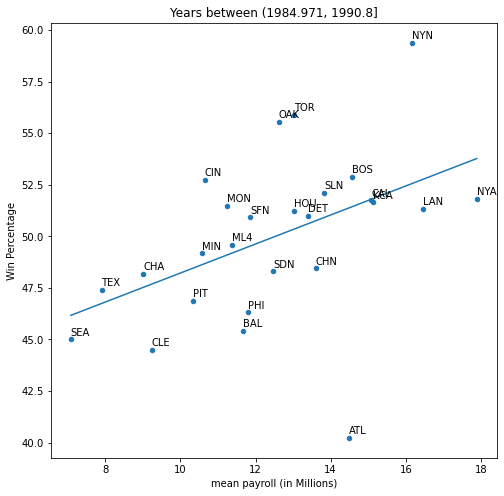

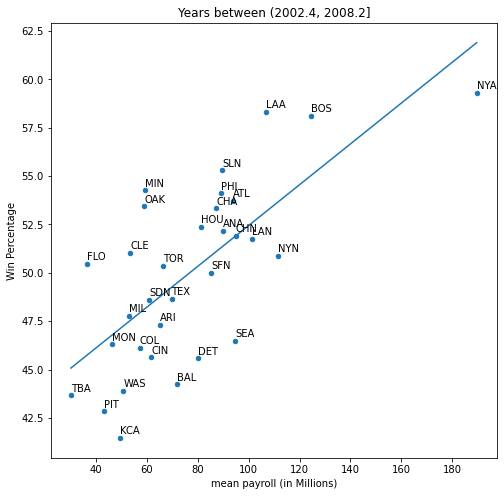

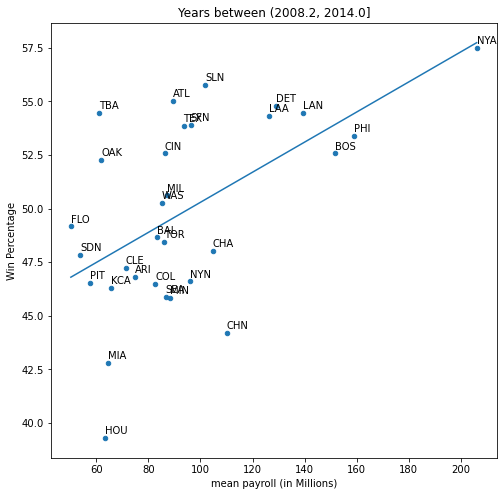

In [5]:
#using bins to split the years into 5 time periods and show win percentage vs payroll
df['bin'] = pd.cut(df.yearID, bins = 5)
bins = pd.unique(df.bin)
for bin in bins:
    curr_bin = df.loc[df['bin'] == bin]
    mean_payroll = curr_bin.groupby('teamID').mean()
    mean_payroll['payroll'] = mean_payroll['payroll'].divide(1000000)
    ax = mean_payroll.plot.scatter(x = 'payroll', y = 'WinningPrcnt', figsize=(8,8))
    ax.set_xlabel('mean payroll (in Millions)')
    ax.set_ylabel('Win Percentage')
    ax.set_title("Years between {}".format(bin))
    x = mean_payroll['payroll']
    y = mean_payroll['WinningPrcnt']
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    for i, points in mean_payroll.iterrows():
        label = points.name
        x = points.payroll
        y = points.WinningPrcnt
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,4))
        
        

The teams that stand out for being good at paying for their wins is Atlanta (except for the years between 1985-1990) and the Los Angeles Angels. There is no one team that is consistenly good at paying for their wins through every bin (period of 5 years). The Oakland A's are also good at paying for their wins on average in most time periods, except for 1991-1996 since they are above the linear regression line in 4/5 of the time period bins.

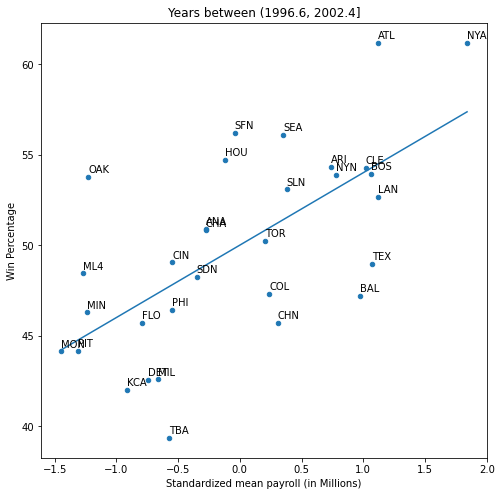

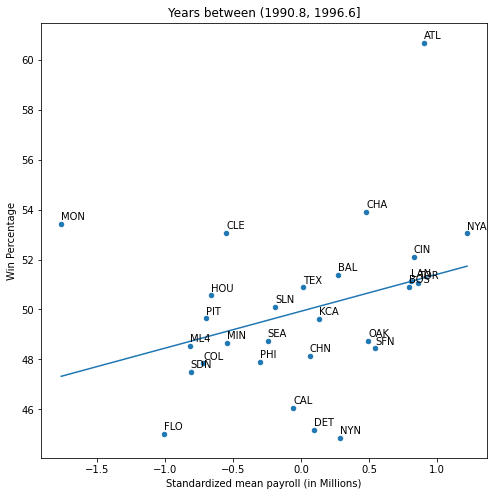

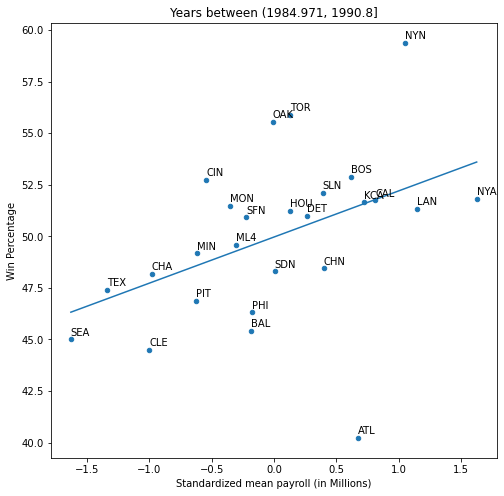

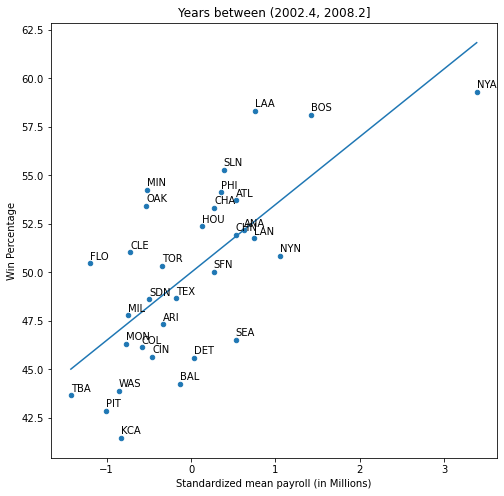

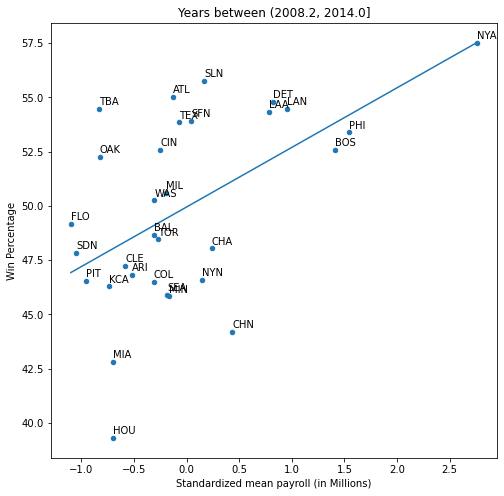

In [6]:
#creating new df and variables to standardize the payroll

mean_df = df.groupby(['teamID', 'yearID']).mean().groupby(['yearID']).mean()
mean_df.drop(['W', 'G', 'WinningPrcnt'], axis=1, inplace=True)
mean_df.rename(columns={"payroll":"mean_payroll"}, inplace=True)

std_df = df.groupby(['teamID', 'yearID']).mean().groupby(['yearID']).std()
std_df.drop(['G', 'W', 'WinningPrcnt'], axis=1, inplace=True)
std_df.rename(columns={"payroll":"std_payroll"}, inplace=True)

temp_df = mean_df.merge(std_df, how='inner', on='yearID')

standardized_df = df.merge(temp_df, how='inner', on='yearID')
standardized_df["standardized_payroll"] = (standardized_df["payroll"] - standardized_df["mean_payroll"]) / standardized_df["std_payroll"]

#repeating same process as before
for bin in bins:
    curr_bin = standardized_df.loc[standardized_df['bin'] == bin]
    mean_payroll = curr_bin.groupby('teamID').mean()
    ax = mean_payroll.plot.scatter(x = 'standardized_payroll', y = 'WinningPrcnt', figsize=(8,8))
    ax.set_xlabel('Standardized mean payroll (in Millions)')
    ax.set_ylabel('Win Percentage')
    ax.set_title("Years between {}".format(bin))
    x = mean_payroll['standardized_payroll']
    y = mean_payroll['WinningPrcnt']
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    for i, points in mean_payroll.iterrows():
        label = points.name
        x = points.standardized_payroll
        y = points.WinningPrcnt
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,4))
        

The new variable does not seem to affect the placements of the points/variables in the graphs.

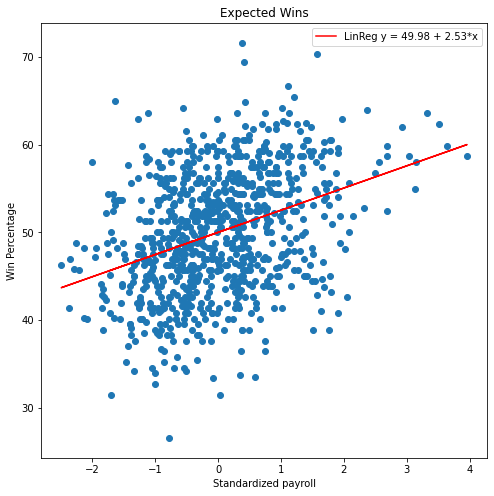

In [7]:
#creating scatter plot

fig, ax = plt.subplots(figsize=(8,8))
x = standardized_df.standardized_payroll
y = standardized_df.WinningPrcnt
ax.scatter(x,y)
m, b = np.polyfit(x,y,1)
ax.plot(x,b+m*x, color = 'red', label = f'LinReg y = {round(b,2)} + {round(m,2)}*x')
ax.set_xlabel('Standardized payroll')
ax.set_ylabel('Win Percentage')
ax.set_title('Expected Wins')
ax.legend()

Average for OAK is 11.139515397135929
Average for BOS is 2.9801395968302096
Average for NYA is 4.334639804164876
Average for ATL is 7.425983775985209
Average for TBA is -7.8754875816793195


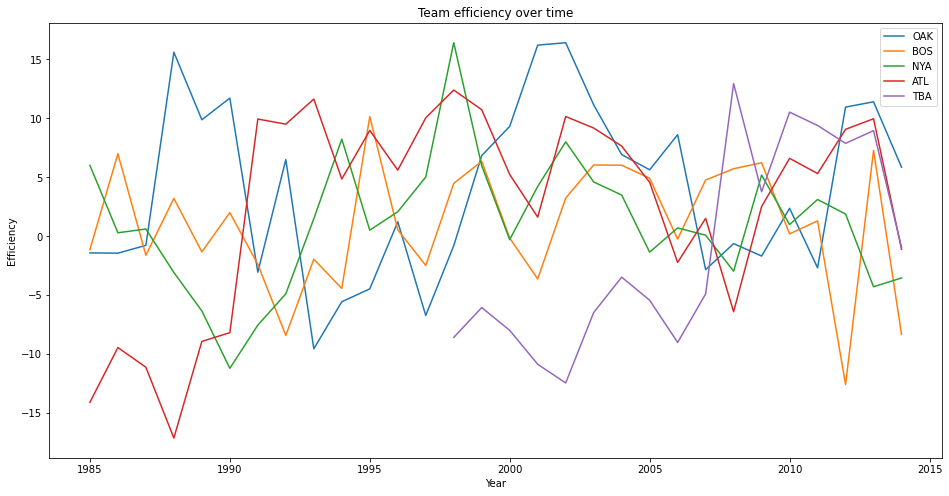

In [8]:
#calculating efficiency
standardized_df['efficiency'] = standardized_df['WinningPrcnt']-(b+standardized_df['standardized_payroll'].multiply(other = m))
fig, ax = plt.subplots(figsize = (16,8))
teams = ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']
team_df = standardized_df[standardized_df['teamID'].isin(teams)] 

for team in teams:
    team_data = standardized_df.loc[standardized_df['teamID'] == team]
    x = team_data.yearID
    y = team_data.efficiency
    x,y = zip(*sorted(zip(x,y),key=lambda x: x[0]))
    ax.plot(x,y, label = team)

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Efficiency')
ax.set_title('Team efficiency over time')

#computing average efficiency for each team in the moneyball period
for team in teams:
    moneyball_avg = (standardized_df.loc[(standardized_df['teamID'] == team) & (standardized_df['yearID'] <= 2004) & (standardized_df['yearID'] >= 1999)]).efficiency.mean()
    print("Average for {} is {}".format(team,moneyball_avg))
    


Oakland's efficiency is the best throughout the moneyball period. Their average efficiency during this period is 11.13, which is higher than the other 4 teams that are on the graph.

This plot has more insigthts in the graphs compared to the ones in question 2 and 3. You can clearly distinugish how good each doing by looking at the efficiency variable and seeing if it is positive or negative. Also, this graph is also more useful because you can see the all time periods instead of seing the average of variables in bins split up by 5 years. It is also easier to see teams that joined the MLB in a specific time period, like 'TBA'.